   Variants  HD  Count input  Count selected   Fitness
0      VDGV   0        92735          338346  1.000000
5      FDGV   1          136             161  0.377101
6      GDGV   1          859             155  0.008298
21     VDCV   1           69              57  0.060713
24     VDFV   1          111              57  0.067022
0.0 3.230076565
0 1
1 16
2 96
3 256
4 256


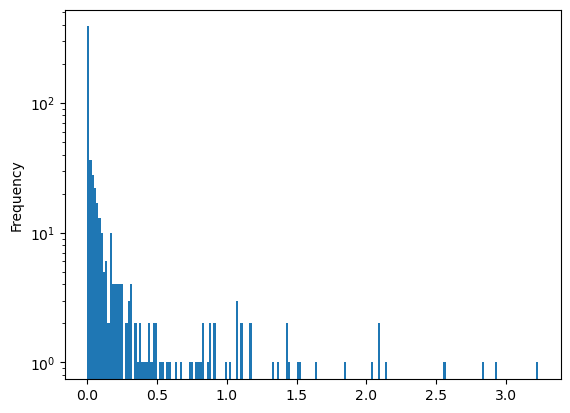

In [1]:
#Generate sequences for all mutations in deep mutational scan covid spike RBD experiment 
#! pip install Bio
import pandas as pd
import Bio
from Bio import SeqIO
from Bio import SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
import numpy as np
import re

# read and get fitness
file = '../data/BD1-supp1.csv'
df = pd.read_csv(file) 

# subset for top 0.1% AAs showing high-order epistasis in quadruple mutants (Fig 2B)
# plus the WT at each site
# site 1: V/W/Y/F/G (5)
# site 2: D/L/Q/E/T (5)
# site 3: G/L/C/F/Y (5)
# site 4: V/P/S/Y/H (5)
df = df[df.Variants.str.match("^[VWYFG][DLQET][GLCFY][VPSYH]")]
print(df.head())

# log scale
plt.figure()
df['Fitness'].plot.hist(bins=200, log=True)

print(min(df['Fitness']), max(df['Fitness']))
#print(df.head())
wt = 'VDGV'

recs = df.to_dict('records')
#print(recs)

# calculate Hamming distances
def aa_dist(wt, hap):
    d = 0;
    for i in range(len(wt)):
        if wt[i] != hap[i]:
            d += 1
    return(d)

#print(aa_dist(wt, 'NDEGEEL'))
wtDict = {}
for rec in recs:
    wtDict[rec['Variants']] = {'fit': rec['Fitness'], 'subset': rec['HD']}

for level in range(5):
    ndPre = [id for id in  wtDict if wtDict[id]['subset'] == level]
    print(level, len(ndPre))
    
df.to_csv("../data/bd1-subset.tsv", sep = "\t", index = False)

In [2]:
# build a directed graph
import networkx as nx

DG = nx.DiGraph() # a directed graph, there is lots of graph algorithms to identify local and global peaks; apply evol algo

# add nodes
for id in wtDict: 
    DG.add_node(id) # add a node with a string name (id)        
    for k in wtDict[id]: # attach features: fit, charge, subset 
        DG.nodes[id][k] = wtDict[id][k]

for level in range(5): # add edge
    ndPre = [id for id in  wtDict if wtDict[id]['subset'] == level]
    ndThis = [id for id in  wtDict if wtDict[id]['subset'] == level + 1]
    #print(ndPre)
    #print(ndThis)
    
    for i in ndPre:
        for j in ndThis:
            if aa_dist(i, j) == 1:
                if wtDict[i]['fit'] < wtDict[j]['fit']: # higher bind for mut    
                    DG.add_edge(j, i)
                else:
                    DG.add_edge(i, j)
#print(len(DG.nodes))
#print(len(DG.edges))
peaks = [x[0] for x in DG.out_degree if x[1] == 0]
vals = [x[0] for x in DG.in_degree if x[1] == 0]
print(len(peaks))
print(len(vals))

82
31


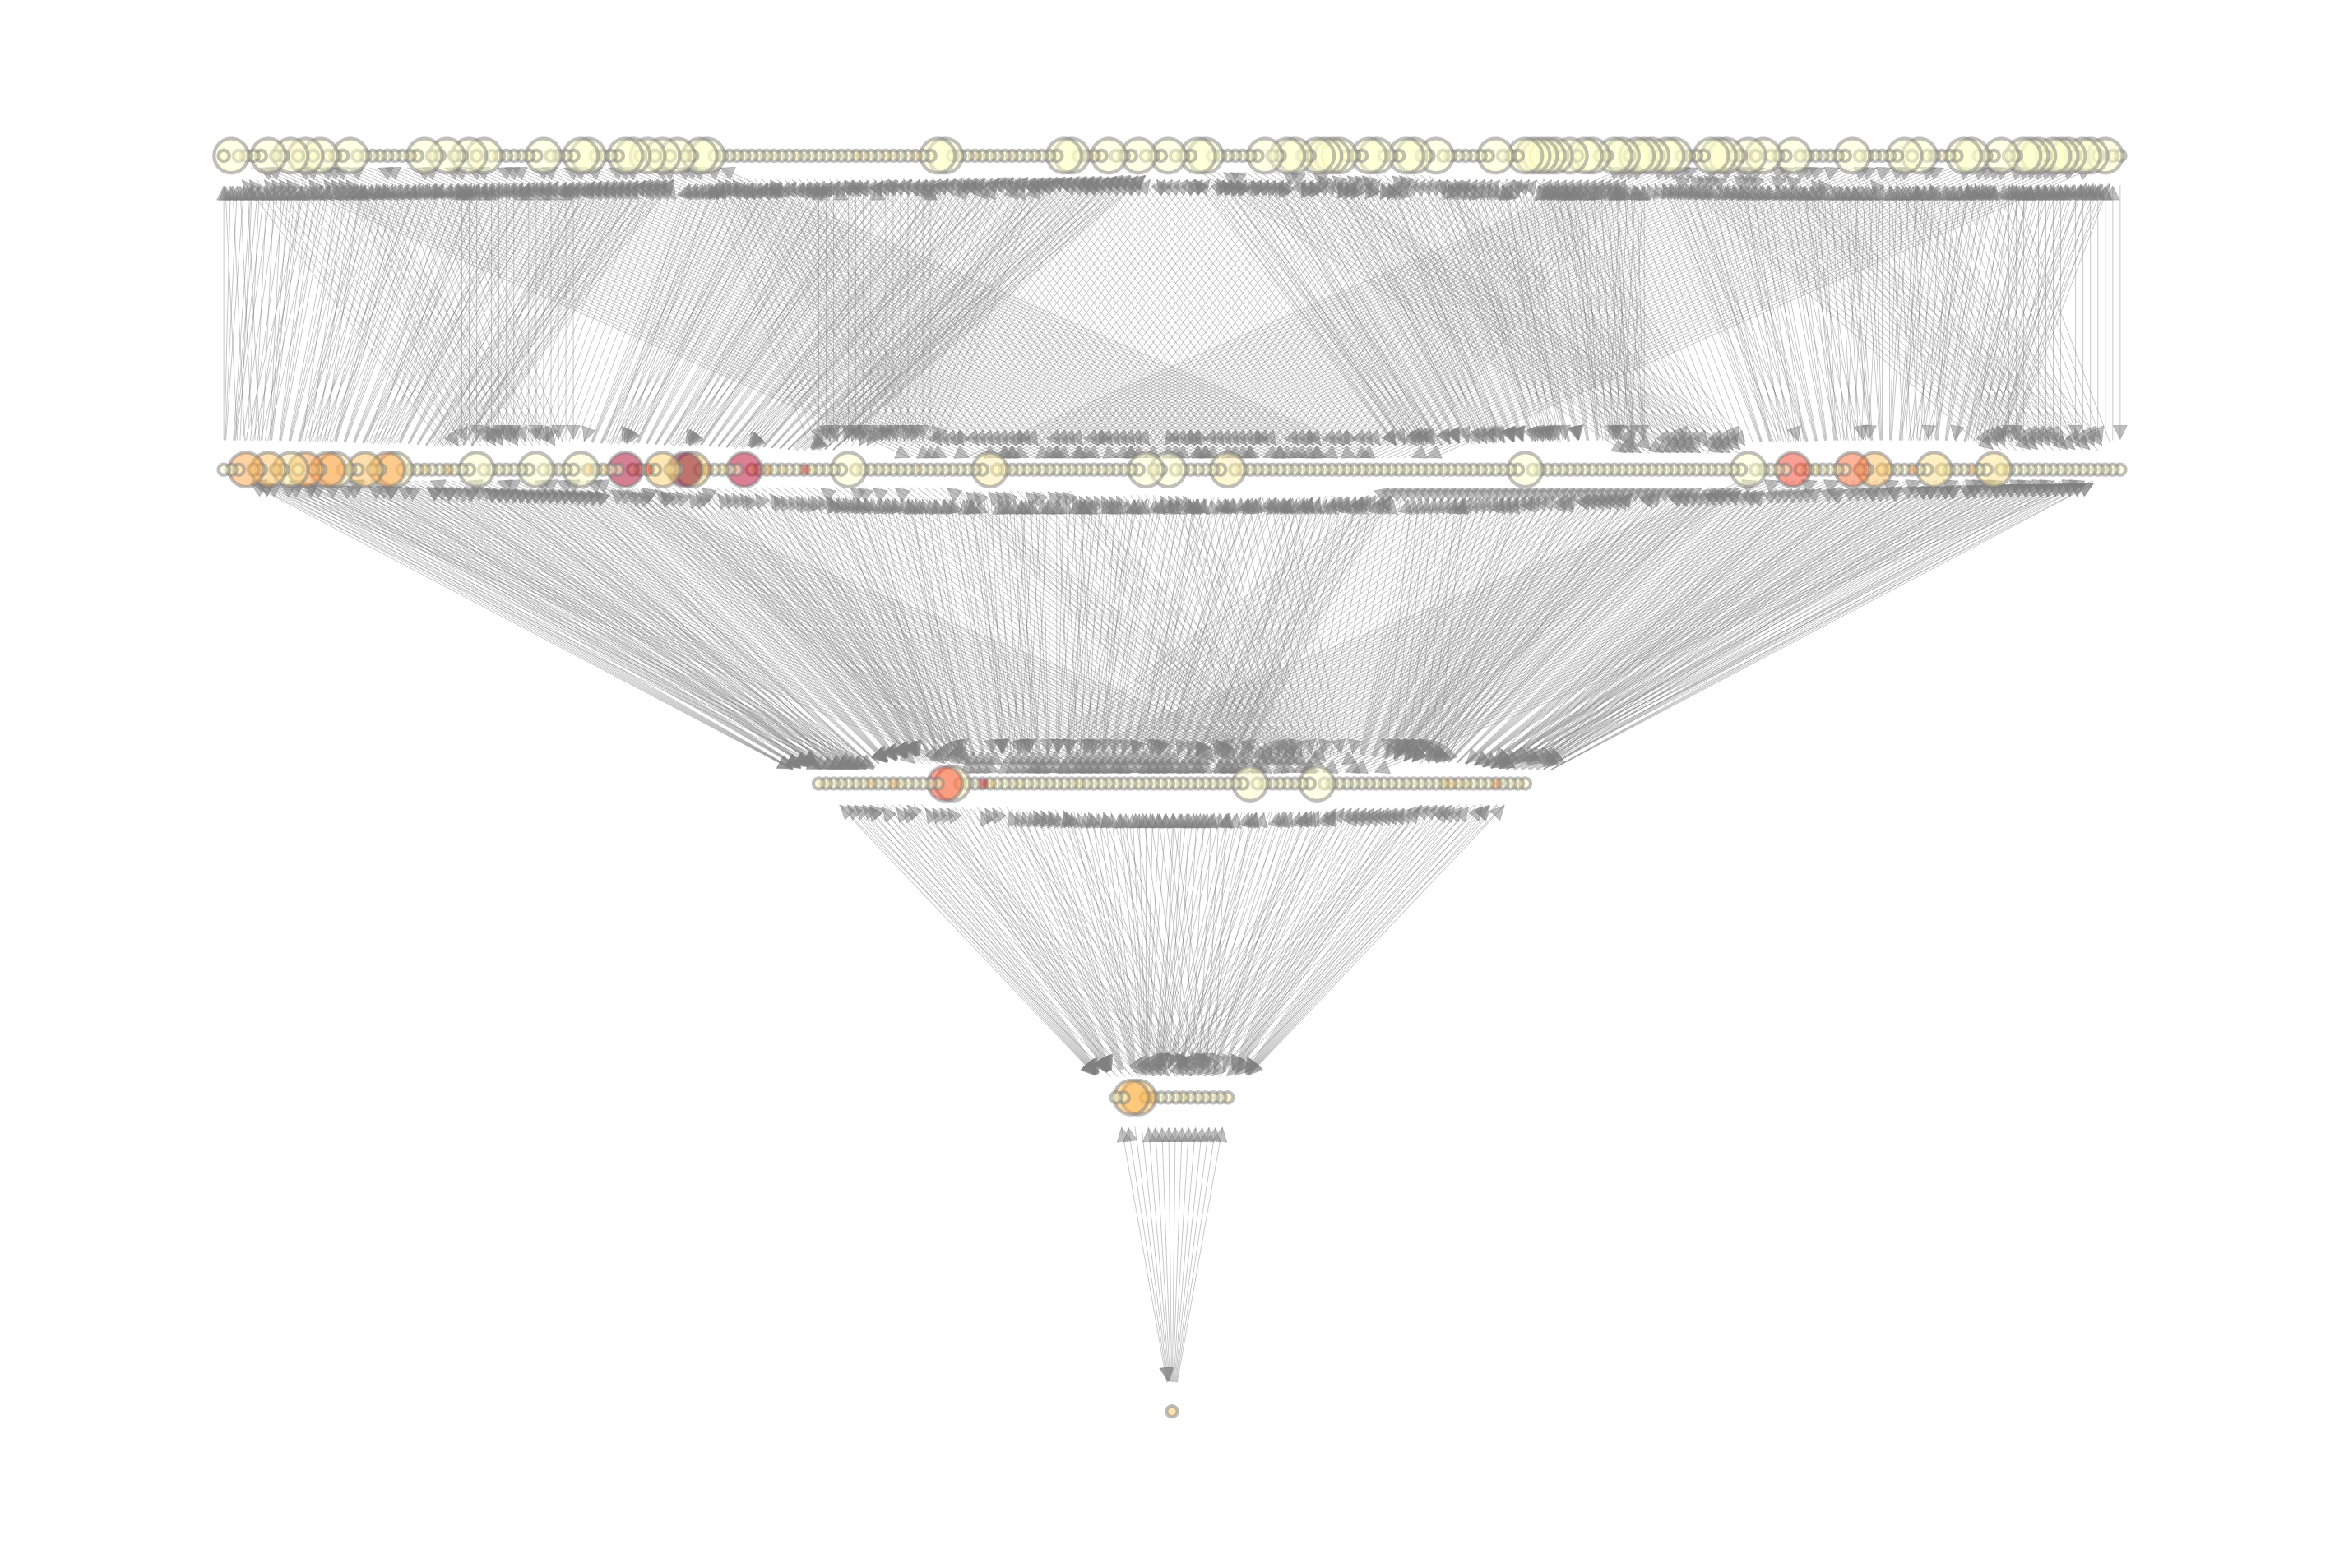

In [3]:
import matplotlib as mpl
import matplotlib.cm as cm

#print(DG)
# map fitness to color map
norm = mpl.colors.Normalize(vmin=min(df['Fitness']), vmax=max(df['Fitness']))
cmap = mpl.cm.YlOrRd
mapper = cm.ScalarMappable(norm=norm, cmap = cmap)
NodeColors = [ mapper.to_rgba(DG.nodes[v]['fit']) for v in DG.nodes ]
ndEdgeColors = []
ndSizes = []
for x in DG.nodes:
    if x in peaks:
        ndEdgeColors.append("red")
        ndSizes.append(100)
    elif x in vals:
        ndEdgeColors.append("blue")
        ndSizes.append(100)
    else:
        ndEdgeColors.append("none")
        ndSizes.append(10)

#EdgeWidth = [ abs(DG.nodes[x[0]]['fit']-DG.nodes[x[1]]['fit'])*5 for x in DG.edges()]

pos = nx.multipartite_layout(DG, align = 'horizontal')
plt.figure(figsize = (12,8), dpi=300)
ec = nx.draw_networkx_edges(DG, pos, width = 0.2, edge_color = "gray", alpha = 0.5)
nc = nx.draw_networkx_nodes(DG, pos, 
                            node_color=NodeColors, 
                            node_size=ndSizes,
                            alpha = 0.5,
                            edgecolors="gray"
                            )
plt.axis('off')
#plt.show()
plt.savefig("bd1.png")

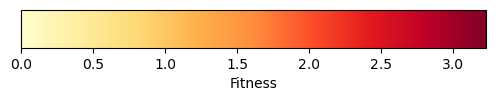

In [6]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Fitness')
plt.savefig("bd-colorbar.pdf")